# Figures for 2/28 presentation

* land masks for each model → what fields have a land mask?
* maps of change
    * surface temperature
    * albedo
    * LAI
    * net radiative flux at TOA
    * precipitation
    * $P-E$
* plots of zonal mean change
    * surface temperature
    * albedo
    * LAI + fractional LAI
    * net radiative flux at TOA
    * precipitation
    * $P-E$

# Setup

In [1]:
import os
import shutil
import glob
import pandas as pd
import numpy as np
import xarray as xr
import pickle as pkl

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import cmocean.cm as cmo

import warnings

In [2]:
## some magic to automatically reload my functions before running a new cell
%load_ext autoreload
## %reload_ext autoreload
%autoreload 1
%aimport my_functions

import my_functions as mf

## Figure settings

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160

# %config InlineBackend.figure_formats = ['pdf']
%config InlineBackend.figure_formats = ['png']

## Load dictionaries

In [4]:
# Get the last 40 years of the 1% CO2 runs and the corresponding time period in piControl
with open('../pkl_files/period_l40_slice_in_pi.pkl', 'rb') as file:
    period_l40_slice_in_pi = pkl.load(file)
with open('../pkl_files/period_l40_start_year_in_pi.pkl', 'rb') as file:
    period_l40_start_year_in_pi = pkl.load(file)
with open('../pkl_files/period_l40_end_year_in_pi.pkl', 'rb') as file:
    period_l40_end_year_in_pi = pkl.load(file)
with open('../pkl_files/start_year_in_pi.pkl', 'rb') as file:
    start_year_in_pi = pkl.load(file)
    
with open('../pkl_files/period_l40_slice_in_co2.pkl', 'rb') as file:
    period_l40_slice_in_co2 = pkl.load(file)
with open('../pkl_files/period_l40_start_year_in_co2.pkl', 'rb') as file:
    period_l40_start_year_in_co2 = pkl.load(file)
with open('../pkl_files/period_l40_end_year_in_co2.pkl', 'rb') as file:
    period_l40_end_year_in_co2 = pkl.load(file) 
with open('../pkl_files/start_year_in_co2.pkl', 'rb') as file:
    start_year_in_co2 = pkl.load(file)


# Get each model's variant_id
with open('../pkl_files/variant_id.pkl', 'rb') as file:
    variant_id = pkl.load(file)
    
# Get each model's table_id
with open('../pkl_files/table_id.pkl', 'rb') as file:
    table_id = pkl.load(file)
    
# Get each model's grid_label
with open('../pkl_files/grid_label.pkl', 'rb') as file:
    grid_label = pkl.load(file)
    
# Colors corresponding to each model
with open('../pkl_files/mcolors.pkl', 'rb') as file:
    mcolors = pkl.load(file)

## Create constants

In [5]:
# Cases / experiments
cases = ['piControl', '1pctCO2', '1pctCO2-rad', '1pctCO2-bgc']
cases_rad = ['1pctCO2', '1pctCO2-rad']

# Models with data in /tiger/scratch/gpfs/GEOCLIM/bgb2/CMIP/ and CMIPmerge/
# --> removed MRI-ESM2-0 because 1pctCO2 and 1pctCO2-rad Amon variables are the same
# --> removed CanESM5 because server could not be reached and model output not available (yet?)

# --> models with HT, VEG for 1pctCO2 and 1pctCO2-rad (i.e., the max number of models used)
models = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CMCC-ESM2',
          'CNRM-ESM2-1', 'EC-Earth3-CC', 'GFDL-ESM4', 'GISS-E2-1-G',
          'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM',
          'UKESM1-0-LL']
#  --> models with HT, VEG, SW for all cases
models_all = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CMCC-ESM2',
              'CNRM-ESM2-1', 'GISS-E2-1-G', 'IPSL-CM6A-LR', 'MIROC-ES2L',
              'MPI-ESM1-2-LR', 'UKESM1-0-LL']
# --> only models with HT, VEG, SW for 1pctCO2 and 1pctCO2-rad
models_radsw = ['EC-Earth3-CC']
# --> only models with HT, VEG for 1pctCO2 and 1pctCO2-rad
models_rad = ['CESM2', 'GFDL-ESM4', 'NorESM2-LM']

# Variables
variables = ['evspsbl', 'hfls', 'hfss', 'hus', 'lai', 'pr', 'prsn', 'ps',
             'rlds',  'rlus', 'rlut', 'rsds', 'rsdt', 'rsus', 'rsut', 'ta',
             'tas', 'uas', 'vas']
variables_ht = ['hfls', 'hfss', 'hus', 'pr', 'prsn', 'ps', 'rlds', 'rlus',
                'rlut', 'rsds', 'rsdt', 'rsus', 'rsut', 'ta']
variables_vegsw = ['evspsbl', 'lai', 'tas', 'uas', 'vas']
variables_veg = ['evspsbl', 'lai', 'tas']
variables_2d = ['evspsbl', 'hfls', 'hfss', 'lai', 'pr', 'prsn', 'ps',
                'rlds',  'rlus', 'rlut', 'rsds', 'rsdt', 'rsus', 'rsut',
                'tas', 'uas', 'vas']
variables_3d = ['hus', 'ta']
variables_nht = ['mht', 'oht', 'aht', 'ahtdry', 'ahtmoist']

# Months
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months_abbr = ['J','F','M','A','M','J','J','A','S','O','N','D']

# Directory where CMIP6 model output lives on tiger
cmipdir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIP/'
cmipmergedir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIPmerge/'
cmipgriddir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIP1x1.25/'
cmipnhtdir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIPnht/'

# Import data

In [13]:
def getcmip(v, m, c, toMerge=True, toInterp=False):
    if not toInterp:
        if table_id[v] == 'fx':
            return xr.open_mfdataset(cmipdir+m+'/'+v+'_'+table_id[v]+'_'+m+'_*_*_'+grid_label[m]+'.nc')
        elif toMerge:
            return xr.open_dataset(cmipmergedir+m+'/'+v+'_'+table_id[v]+'_'+m+'_'+c+'_'+variant_id[m]+'_'+grid_label[m]+'.nc')
        elif not toMerge:
            return xr.open_mfdataset(cmipdir+m+'/'+v+'_'+table_id[v]+'_'+m+'_'+c+'_'+variant_id[m]+'_'+grid_label[m]+'_*.nc')
        
    if toInterp:
        if table_id[v] == 'fx':
            return xr.open_mfdataset(cmipdir+m+'/'+v+'_'+table_id[v]+'_'+m+'_*_*_'+grid_label[m]+'.nc')
        else:
            return xr.open_mfdataset(cmipgriddir+m+'/'+v+'_'+table_id[v]+'_'+m+'_'+c+'_'+variant_id[m]+'_1x1.25_*.nc')

In [ ]:
%%time

## Set up dictionaries for storing data
# Precip and P-E
pr = {}
evspsbl = {}
pe = {}

# Albedo
rsus = {}
rsds = {}
alb = {}

# Vegetation (LAI)
lai = {}
dfrlai = {}

# Surface temperature
tas = {}

# Net radiative flux at TOA
rsut = {}
rsdt = {}
rlut = {}
rldt = {}
netr = {}

area = {}
lf = {}
landmask = {}

# Set a minimum threshold for (perturbed-control) when computing the fractional change in lai
# Below the threshold, just set frac delta lai = 0
laithresh = 0.001

# Set a minimum threshold for land mask
landthresh = 0.1

# Load merged fields
toMerge = True
toInterp = False
# area = getcmip('areacella', 'GFDL-ESM4', 'piControl', toMerge=toMerge, toInterp=toInterp)['areacella']
# lf = getcmip('sftlf', 'GFDL-ESM4', 'historical', toMerge=toMerge, toInterp=toInterp)['sftlf']
# landmask = xr.where(lf>landthresh,1,0)

## Retrieve the data
for m in models:
    print(m)
    tslice = period_l40_slice_in_co2[m]
    
    pr[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    evspsbl[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    pe[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    rsus[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    rsds[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    alb[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    lai[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    tas[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    rsut[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    rsdt[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    rlut[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    netr[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    # Try to get grid cell area
    try:
        area[m] = getcmip('areacella', m, None, toMerge=toMerge, toInterp=toInterp)['areacella']
    except: print('    missing areacella field')
        
    # Try to get land fraction and create land mask
    isLM = False
    try:
        lf[m] = getcmip('sftlf', m, None, toMerge=toMerge, toInterp=toInterp)['sftlf']
        landmask[m] = xr.where(lf[m]>landthresh,1,0)
        isLM = True
        print('land', lf[m].shape, landmask[m].shape)
    except: print('    missing sftlf field')
    
    for c in cases_rad:
        pr[m][c] = getcmip('pr', m, c, toMerge=toMerge, toInterp=toInterp)['pr'].sel(time=tslice) * 86400
        evspsbl[m][c] = getcmip('evspsbl', m, c, toMerge=toMerge, toInterp=toInterp)['evspsbl'].sel(time=tslice) * 86400
        pe[m][c] = pr[m][c] - evspsbl[m][c]
        
        rsus[m][c] = getcmip('rsus', m, c, toMerge=toMerge, toInterp=toInterp)['rsus'].sel(time=tslice)
        rsds[m][c] = getcmip('rsds', m, c, toMerge=toMerge, toInterp=toInterp)['rsds'].sel(time=tslice)
        alb[m][c] = rsus[m][c] / rsds[m][c]
        
        if isLM:
            lai[m][c] = getcmip('lai', m, c, toMerge=toMerge, toInterp=toInterp)['lai'].sel(time=tslice)
            print('lai', lai[m][c].shape)
            lai[m][c] = lai[m][c].where(landmask[m]==1)
            if lai[m][c].shape != pr[m][c].shape: print('    dimension mismatch')
        if not isLM:
            lai[m][c] = getcmip('lai', m, c, toMerge=toMerge, toInterp=toInterp)['lai'].sel(time=tslice)
        
        tas[m][c] = getcmip('tas', m, c, toMerge=toMerge, toInterp=toInterp)['tas'].sel(time=tslice)
        
        rsut[m][c] = getcmip('rsut', m, c, toMerge=toMerge, toInterp=toInterp)['rsut'].sel(time=tslice)
        rsdt[m][c] = getcmip('rsdt', m, c, toMerge=toMerge, toInterp=toInterp)['rsdt'].sel(time=tslice)
        rlut[m][c] = getcmip('rlut', m, c, toMerge=toMerge, toInterp=toInterp)['rlut'].sel(time=tslice)
        netr[m][c] = rsdt[m][c] - rlut[m][c] - rsut[m][c]
    
    difflai = lai[m]['1pctCO2'] - lai[m]['1pctCO2-rad']
    dfrlai[m] = xr.where(abs(difflai)>laithresh, difflai/(lai[m]['1pctCO2']+lai[m]['1pctCO2-rad']), 0)

ACCESS-ESM1-5
land (145, 192) (145, 192)


/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime

lai (480, 145, 192)


/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime

lai (480, 145, 192)


/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime

BCC-CSM2-MR
    missing areacella field
    missing sftlf field
CESM2
land (192, 288) (192, 288)


/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


lai (480, 192, 288)
    dimension mismatch
lai (480, 192, 288)
    dimension mismatch
CMCC-ESM2
land (192, 288) (192, 288)
lai (480, 192, 288)
    dimension mismatch
lai (480, 192, 288)
    dimension mismatch
CNRM-ESM2-1
land (128, 256) (128, 256)
lai (480, 128, 256)
lai (480, 128, 256)
EC-Earth3-CC
    missing sftlf field
GFDL-ESM4
land (180, 288) (180, 288)
lai (480, 180, 288)
lai (480, 180, 288)
GISS-E2-1-G
land (90, 144) (90, 144)
lai (480, 90, 144)
lai (480, 90, 144)
IPSL-CM6A-LR
land (143, 144) (143, 144)
lai (480, 143, 144)
lai (480, 143, 144)
MIROC-ES2L
land (64, 128) (64, 128)
lai (480, 64, 128)
lai (480, 64, 128)
MPI-ESM1-2-LR
land (96, 192) (96, 192)
lai (480, 96, 192)
    dimension mismatch
lai (480, 96, 192)
    dimension mismatch
NorESM2-LM
land (96, 144) (96, 144)
lai (480, 96, 144)
    dimension mismatch
lai (480, 96, 144)


In [25]:
pr[m][c].shape == (480, 192, 288)

True

# Computations

## Zonal mean

In [22]:
## Set up dictionaries for storing data
pr_zm = {}
pe_zm = {}
alb_zm = {}
lai_zm = {}
dfrlai_zm = {}
tas_zm = {}
netr_zm = {}

## Area-weighted zonally average fields
for m in models:
    print(m)
    pr_zm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    pe_zm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    alb_zm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    lai_zm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    tas_zm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    netr_zm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    coslats = np.cos(np.deg2rad(pr[m]['1pctCO2'].lat.values))
    
    for c in cases_rad:
        pr_zm[m][c] = pr[m][c].mean(dim='lon')*coslats
        pe_zm[m][c] = pe[m][c].mean(dim='lon')*coslats
        alb_zm[m][c] = alb[m][c].mean(dim='lon')*coslats
        lai_zm[m][c] = lai[m][c].mean(dim='lon')*coslats
        tas_zm[m][c] = lai[m][c].mean(dim='lon')*coslats
        netr_zm[m][c] = lai[m][c].mean(dim='lon')*coslats
        
    dfrlai_zm[m] = dfrlai[m].mean(dim='lon')*coslats

ACCESS-ESM1-5
BCC-CSM2-MR
CESM2


ValueError: operands could not be broadcast together with shapes (480, 2) (192,)

In [23]:
lai['CESM2'][c]

<xarray.DataArray 'lai' (time: 480, lat: 2, lon: 288)>
dask.array<where, shape=(480, 2, 288), dtype=float32, chunksize=(480, 2, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0101-01-15 12:00:00 ... 0140-12-15 12:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 90.0
Attributes: (12/19)
    standard_name:  leaf_area_index
    long_name:      Leaf Area Index
    units:          1
    cell_measures:  area: areacella
    cell_methods:   area: mean where land time: mean
    comment:        A ratio obtained by dividing the total upper leaf surface...
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Leaf Area Index
    type:           real
    variable_id:    lai

# Misc

## Playing around with zonal averaging techniques

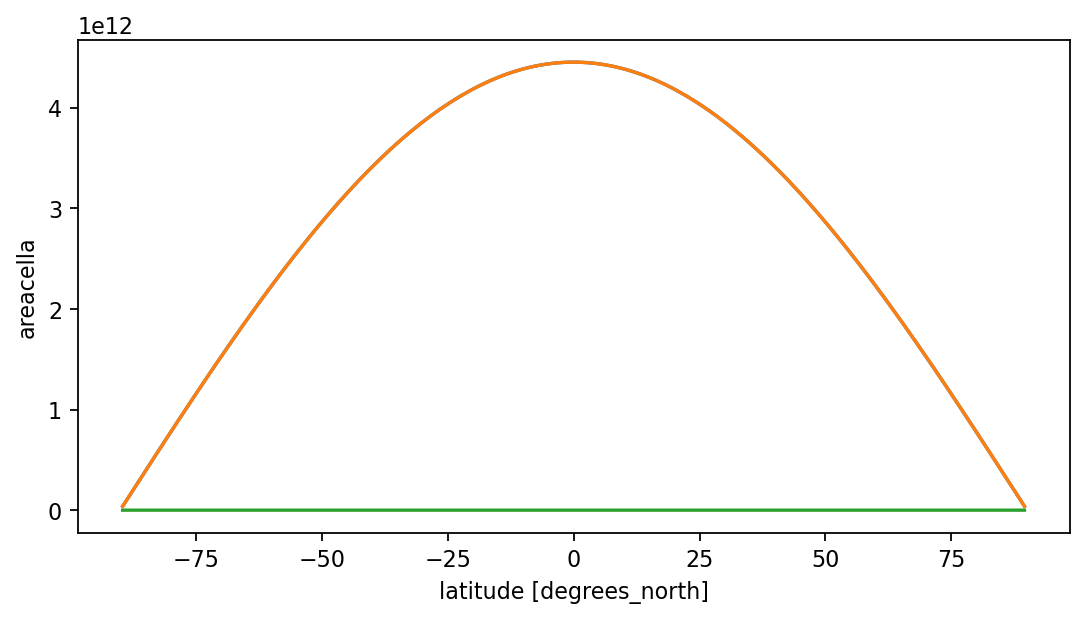

In [56]:
fig,ax = plt.subplots(figsize=(8,4))

area.sum(dim='lon').plot(ax=ax)
ax.plot(area.lat.values, 4.4509257e12*np.cos(np.deg2rad(area.lat.values)))
ax.plot(area.lat.values, area.sum(dim='lon').values - 4.4509257e12*np.cos(np.deg2rad(area.lat.values)))

In [63]:
## Set up dictionaries for storing data
pr_azm = {}
pe_azm = {}
alb_azm = {}
lai_azm = {}
dfrlai_azm = {}
tas_azm = {}
netr_azm = {}

globarea = area.sum(dim=['lon','lat'])
latarea = area.sum(dim='lon')

## Area-weighted zonally average fields
for m in models:
    pr_azm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    pe_azm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    alb_azm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    lai_azm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    tas_azm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    netr_azm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    coslats = np.cos(np.deg2rad(pr[m]['1pctCO2'].lat.values))
    
    for c in cases_rad:
        pr_azm[m][c] = (pr[m][c]*area).sum(dim='lon')/latarea.sum()
        pe_azm[m][c] = (pe[m][c]*area).sum(dim='lon')/latarea.sum()
        alb_azm[m][c] = (alb[m][c]*area).sum(dim='lon')/latarea.sum()
        lai_azm[m][c] = (lai[m][c]*area).sum(dim='lon')/latarea.sum()
        tas_azm[m][c] = (tas[m][c]*area).sum(dim='lon')/latarea.sum()
        netr_azm[m][c] = (netr[m][c]*area).sum(dim='lon')/latarea.sum()
        
    dfrlai_azm[m] = (dfrlai[m].sum(dim='lon')*latarea/latarea.sum())

Text(0, 0.5, '$cos(\\phi)$-weighted $P$')

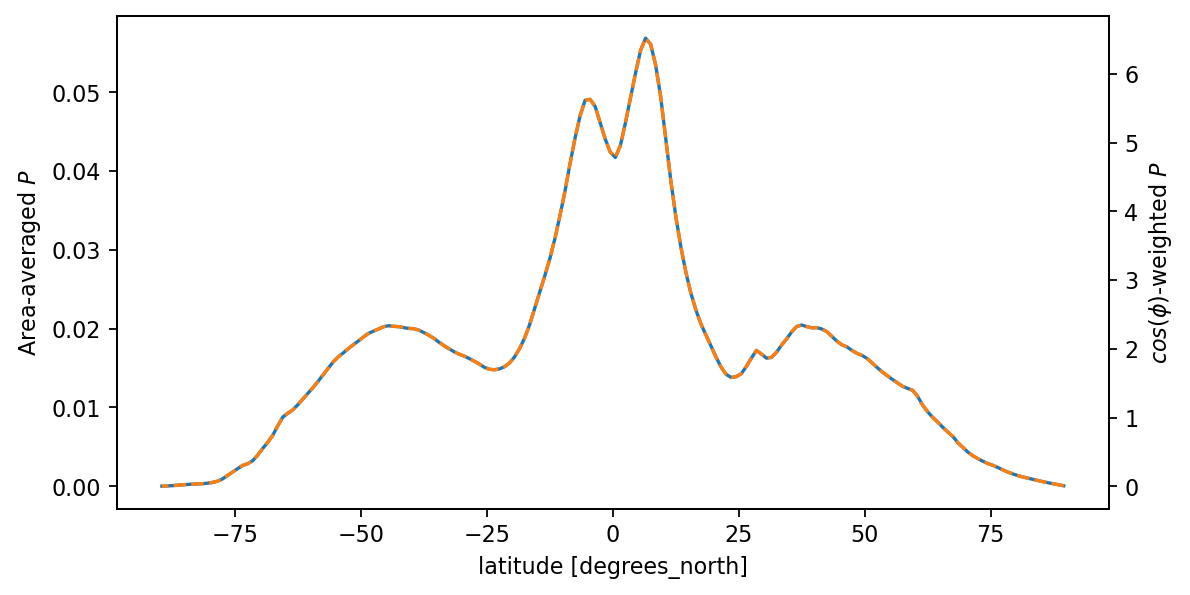

In [73]:
fig,ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

pr_azm['GFDL-ESM4']['1pctCO2'].mean(dim='time').plot(ax=ax1,color='tab:blue')
pr_zm['GFDL-ESM4']['1pctCO2'].mean(dim='time').plot(ax=ax2,color='tab:orange',ls='--')

ax1.set_ylabel('Area-averaged $P$')
ax2.set_ylabel('$cos(\phi)$-weighted $P$')